### This is the code to grid search some parameters to create an RNN model
#### References:
- Peixeiro, M. (2022). Time series forecasting in Python. Manning. Includes the codes fromi its GitHub repo (https://github.com/marcopeix/AppliedTimeSeriesForecastingInPython). Contribution: The technique for converting the series into sequenced samples and the idea for scale and reeschale data after predictions.
- Discolll, N. (2024, January 12). Harnessing RNNs for Financial Time Series Analysis: A Python Approach. Medium. https://medium.com/@redeaddiscolll/harnessing-rnns-for-financial-time-series-analysis-a-python-approach-0669b3a25c7a. Contribution: EarlyStopping function for the RNN model.

#### Packages
- Package Pandas (2.2). (2024). [Python]. https://pandas.pydata.org/
- Package NumPy (1.23). (2023). [Pyhton]. https://numpy.org/ - Harris, C. R., Millman, K. J., Van Der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., Van Kerkwijk, M. H., Brett, M., Haldane, A., Del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2
- Droettboom, J. D. H., Michael. (2024). Package matplotlib (3.8.4) [Python]. https://matplotlib.org
- Package scikit-learn (1.4). (2024). [Pyhton]. https://scikit-learn.org/stable/index.html
- Package Tensorflow (2.16). (2024). [Python]. https://github.com/tensorflow


In [8]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random

import useful_functions as uf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1_l2
from tensorflow.random import set_seed

In [25]:
# load data
#file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/data_cleaned_RF.csv'
file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'

# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# define the target variable as the first column
target_variable = df_raw.columns[0]

# Convert all columns to float
df_raw = df_raw.astype('float64')

# Define threshold to remove outliers
#remove_outliers_threshold = np.nan
remove_outliers_threshold = 0.20

In [27]:
# Effectively remove outliers
if not pd.isna(remove_outliers_threshold):
    df_cleaned = uf.remove_outliers(df_raw.copy(), threshold=remove_outliers_threshold) # in case the threshold is defined
else:
    df_cleaned = df_raw.copy() # in case the threshold is not defined (NaN)

# After removing outliers, fill missing values
df_adjusted = uf.fill_missing_values(df_cleaned)

In [29]:
# Define test and validation set sizes
val_size = 48 # 48 months or 4 years
test_size = 48 # 48 months or 4 years

# Split the data into train and test sets
train_raw_total = df_adjusted.copy()[:-test_size]
train_raw = train_raw_total[:-val_size]
val_raw = train_raw_total[-val_size:]
test_raw = df_adjusted.copy()[-test_size:] # Last 48 months

# Fill missing values
df_train = uf.fill_missing_values(train_raw)
df_val = uf.fill_missing_values(val_raw)
df_test = uf.fill_missing_values(test_raw)


In [30]:
# Let's scale the dfs
# Define the scaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train) # Fit and transform the train set
scaled_val = scaler.transform(df_val) # Transform the validation set
scaled_test = scaler.transform(df_test) # Transform the test set

# include df columns names in the train and test sets
train = pd.DataFrame(scaled_train, columns=df_train.columns)
val = pd.DataFrame(scaled_val, columns=df_val.columns)
test = pd.DataFrame(scaled_test, columns=df_test.columns)

# Include the index in the train and test sets
train.index = df_train.index
val.index = df_val.index
test.index = df_test.index


### Reshape the data

In [31]:
# Converting the series to samples
# We will use the past 12 months to predict the month in an horizon of 12 months

# Define the function to create the samples
def createXY(dataset, n_past, n_future):
    dataX, dataY = [], [] # Initialize the lists
    # Loop for the entire dataset
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)  # Past n months
        dataY.append(dataset.iloc[i + n_future - 1, 0])  #
    return np.array(dataX), np.array(dataY)

n_past = 12  # Number of past months to use
n_future = 12  # future horizon

# Create the samples for the train, validation and test sets
X_train, Y_train = createXY(train, n_past, n_future)
X_val, Y_val = createXY(val, n_past, n_future)
X_test, Y_test = createXY(test, n_past, n_future)


### Let's grid to find the best parameters

In [ ]:
# Let´s define the seed for reproducibility

def func_set_seed(seed=42):
    np.random.seed(seed)
    python_random.seed(seed)
    set_seed(seed) #tensorflow.random.set_seed(seed)

# Call the function to set the seed
func_set_seed(42)

In [ ]:
### Build a RNN model testing different parameters

# Function to build the model
def build_model(n_layers = 2, # Number of hidden layers
                optimizer='adam', # Optimizer
                learning_rate=0.001, # Learning rate of the optimizer
                rnn_units={0: 50,  1: 20, 2: 10}, # Number of units in each layer
                #alphas_l1_l2=0.01, # Removed because it didn't improve the model
                dropout_rate=0.2 # Dropout rate to avoid overfitting
                ):
    # Check the optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    # Create the model
    model = Sequential()
    # Define the input layer shape
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    # Add the RNN layers
    for i in range(n_layers):
        if i < n_layers - 1:  # intermediate hidden layers
            model.add(SimpleRNN(units=rnn_units[i+1], 
                                #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), # Removed because it didn't improve the model
                                #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), # Removed because it didn't improve the model
                                #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), # Removed because it didn't improve the model
                                return_sequences=True))
            model.add(Dropout(dropout_rate))
        else:  # last hidden layer
            model.add(SimpleRNN(units=rnn_units[i+1],  
                                #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), # Removed because it didn't improve the model
                                #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), # Removed because it didn't improve the model
                                #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), # Removed because it didn't improve the model
                                return_sequences=False))
            model.add(Dropout(dropout_rate)) # Dropout layer to avoid overfitting
    model.add(Dense(units=1)) #output layer
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Function to test each set of parameters
def custom_fit(params):
    training_params = {key: params[key] for key in params if key in ['n_layers', 
                                                                     #'alphas_l1_l2', 
                                                                     'dropout_rate',
                                                                     'rnn_units', 
                                                                     'optimizer', 
                                                                     'learning_rate']} # Use this to pass the parameters to the model
    model = build_model(**training_params) # Create the model using the parameters
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Stop training when the validation loss is no longer decreasing after X epochs

    # Fitting the model with early stopping
    model.fit(X_train, Y_train, 
              epochs=params['epochs'], 
              batch_size=params['batch_size'], 
              verbose=0,
              validation_data=(X_val, Y_val), 
              callbacks=[early_stopping])
    # Compute the loss on the validation set
    loss = model.evaluate(X_val, Y_val, verbose=0)
    return loss

# Parameters to test with possible coefficients
param_grid = {
    'dropout_rate': [0.1, 0.2, 0.3],
    #'alphas_l1_l2' : [0.001, 0.01, 0.1, 1], # Removed because it didn't improve the model
    'batch_size': [32, 64, 128],
    'epochs': [20, 50, 75, 100],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.01, 0.001, 0.0001], # Learning rate
    'n_layers': [1,2,3], # Number of hidden layers
    'rnn_units' : [{1: 10,  2: 10, 3: 5},
                   {1: 50,  2: 30, 3: 15},
                   {1: 100,  2: 100, 3: 50}, {1: 200,  2: 200, 3: 100}, {1: 400,  2: 300, 3: 100}]  
}

# Compare the scores for each set of parameters
best_score = np.inf # Initialize the best score object
best_params = None # Initialize the best parameters object
interactions = 1 # Initialize the interactions counter
for params in ParameterGrid(param_grid): # Loop through the parameters
    # Print the parameters and the iteration to keep track of the progress
    print("Applying parameters: ", params,". This is the ", interactions, "th iteration")
    interactions += 1 # increment the interactions counter
    score = custom_fit(params) # Compute the score
    if score < best_score: # Check if the score is better than the best score
        best_score = score # Update the best score
        best_params = params # Update the best parameters

# Print the best score and the best parameters
print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

: 

In [ ]:
# Now let's build the model with the best parameters and train it
# Get epochs and batch_size from best_params
best_params_bkp = best_params.copy() # Just to keep a backup of the best parameters
epochs = best_params.pop('epochs') # Remove the epochs from the best parameters
batch_size = best_params.pop('batch_size') # Remove the batch_size from the best parameters

# build the model
best_model = build_model(**best_params)

In [ ]:
# Save the best model. Therefore we can use it later
best_model.save('models_parameters/best_rnn_model_grid_lasso_10.keras')  # Saves the model to a keras file

In [ ]:
# #If we need to restore the best model

# # Load the model from the file
# best_model = load_model('models_parameters/best_rnn_model_grid_lasso_10.keras')
# # from manual hyperparameter tuning
# epochs = 75
# batch_size = 64



In [ ]:
# Now let's train the model and make predictions on validation set

# train the model
history = best_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=0)

# Make predictions on the validation set
predictions_scaled = best_model.predict(X_val)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


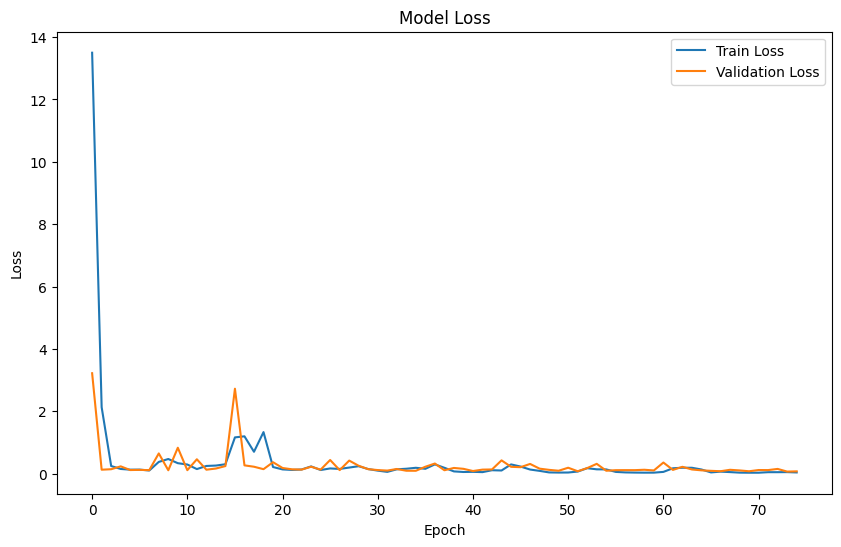

In [ ]:
# Plot training and validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_scaled_2d = predictions_scaled.reshape(-1, 1)
# Get the last timestep of X_val
X_val_last_timestep = X_val[:, -1, :]
# Replace the first column of X_val_last_timestep with the scaled predictions.
X_val_last_timestep[:, 0] = predictions_scaled_2d[:, 0]
# unscale the predictions
predictions_rescaled = scaler.inverse_transform(X_val_last_timestep)[:, 0]

# unscale the Y_val
Y_val_rescaled = scaler.inverse_transform(val.iloc[-len(predictions_scaled):, :].values)[:, 0]

# Calculate the validation error
mape_RNN_val = mean_absolute_percentage_error(Y_val_rescaled, predictions_rescaled)
rmse_RNN_val = np.sqrt(mean_squared_error(Y_val_rescaled, predictions_rescaled))
mae_RNN_val = mean_absolute_error(Y_val_rescaled, predictions_rescaled)

print(f'MAPE RNN: {mape_RNN_val}')
print(f'RMSE RNN: {rmse_RNN_val}')
print(f'MAE RNN: {mae_RNN_val}')

MAPE RNN: 0.7118257284164429
RMSE RNN: 13475.2001953125
MAE RNN: 11037.2236328125


In [ ]:
# Let's predict the test set using the best model
predictions_test_scaled = best_model.predict(X_test)

# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_test_scaled_2d = predictions_test_scaled.reshape(-1, 1)
# Get the last timestep of X_test
X_test_last_timestep = X_test[:, -1, :]
# Replace the first column of X_test_last_timestep with the scaled predictions.
X_test_last_timestep[:, 0] = predictions_test_scaled_2d[:, 0]
# unscale the predictions
predictions_test_rescaled = scaler.inverse_transform(X_test_last_timestep)[:, 0]

# Let's convert the predictions and Y_test to a dataframe usind the index from test
predictions_test_df = pd.DataFrame(predictions_test_rescaled, index=test.index[-len(predictions_test_rescaled):], columns=[target_variable])
predictions = predictions_test_df.copy()

# Get the original Y_test
Y_test = df_adjusted[-len(predictions):][target_variable]


In [ ]:
# Calculate the error on the test set
mape_best_RNN = mean_absolute_percentage_error(Y_test, predictions)
rmse_best_RNN = np.sqrt(mean_squared_error(Y_test, predictions))
mae_best_RNN = mean_absolute_error(Y_test, predictions)

print(f'MAPE best RNN: {mape_best_RNN}')
print(f'RMSE best RNN: {rmse_best_RNN}')
print(f'MAE best RNN: {mae_best_RNN}')

MAPE best RNN: 0.8002790808677673
RMSE best RNN: 20576.998046875
MAE best RNN: 16216.87890625


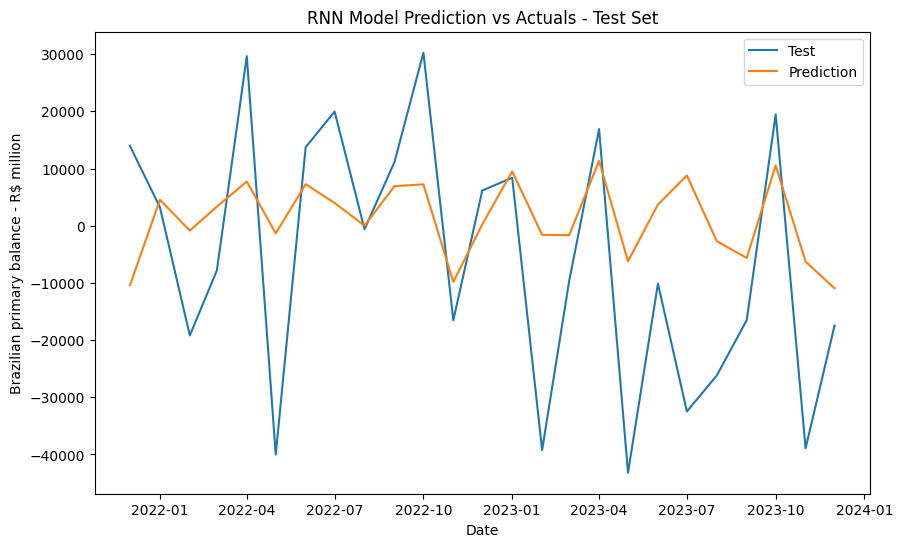

In [ ]:
# Plot RNN best Model predictions vs Actuals - Test Set

# Convert Y_test_rescaled to a dataframe using the test index
Y_test_rescaled_df = pd.DataFrame(Y_test, index=Y_test.index)
# Change the column name to the target variable
Y_test_rescaled_df.columns = [target_variable]

uf.plot_prediction_vs_test(
    target_variable, 
    Y_test_rescaled_df[target_variable],
    predictions,
    #predictions_test_rescaled, 
    'RNN Model Prediction vs Actuals - Test Set',)